In [1]:
import binascii

import hashlib

In [2]:
NUMBER_BYTES = 3

In [3]:
class Entidad:
    """
    Clase que modela las entidades que desean  comunicarse.


    Attributes
    ----------
    nombre: string
        Nombre identificatorio de la entidad.
   
    Methods
    -------
    
    """
    def __init__(self,nombre=''):
        self.nombre = nombre
        self.bd = []
        
    def generacionClave(self,number_bytes): 
        rsa = RSA()
        self.claves = rsa.generarClaves(number_bytes)
        
    def claves_publicas(self):
        return {
            'e':self.claves['e'],
            'n':self.claves['n']
        }
    
    def buscar(self,nombre):
        for record in self.bd:
            if record['name']==nombre:
                   return record
        return False
    
    def añadirDatos(self,datos):
        if datos != False:
             self.bd.append(datos) 
    
    def textoCifrado(self,entidadDestino,msje):
        rsa = RSA()
        texto = rsa.cifrarTexto(msje=msje,claves=self.buscar(entidadDestino))
        return texto
    
    def descifrar(self,msje):
        rsa = RSA()
        texto = rsa.descifrarTexto(msje=msje,d=self.claves['d'],n=self.claves['n'])
        return texto
    
    def firmarMensaje(self,msje):
        rsa = RSA()
        texto = rsa.firmar(msje=msje,d=self.claves['d'],n=self.claves['n'])
        return texto
    
    def verificarFirma(self,entidad,msje,firma):
        rsa = RSA()
        v = rsa.verificarFirma(msje=msje,firma=firma,claves=self.buscar(entidad))
        return v

In [4]:
class CA:
    """
    Clase que representa el CA


    Attributes
    ----------
    bd: [array[string]]
        Base de datos de las claves publicas.

    Methods
    -------
    añadir(array[nombre,e,n])
        Recibe desde una entidad los datos necesarios para guardar la clave pública.
    buscar(string nombre)
        Busca una entidad por nombre y devuelve los datos de la clave pública.
        
    """
    def __init__(self):
        self.bd = []
        
    def añadir(self,nombre,clave_publica):
        if(self.buscar(B.nombre)==False):
            self.bd.append({
                'name':nombre,
                'e': clave_publica['e'],
                'n': clave_publica['n']
            })
            
    def buscar(self,nombre):
        for record in self.bd:
            if record['name']==nombre:
                   return record
        return False;

In [5]:
class RSA:
    """
    Clase que representa el algoritmo RSA.


    Attributes
    ----------
    
    
    Methods
    -------
    
    """
    def generarClaves(self,number_bytes):
        p = obtenerPrimo(bits = number_bytes * 8)
        q = obtenerPrimo(bits = number_bytes * 8)
        while(p == q):
            q = obtenerPrimo(bits = number_bytes * 8)
        n = p*q
        phi = (p-1) * (q-1)
        e = obtenerCoPrimo(n=phi,li=1,ls=phi)
        d = inversoModN(a=e,n=phi)

        return {
            'p':p,
            'q':q,
            'n':n,
            'phi':phi,
            'e':e,
            'd':d
        }
    
    def cifrarTexto(self,msje,claves):
        e = claves['e']
        n = claves['n']
        msje = msje.encode()
        m = int.from_bytes(msje, byteorder='big')
        c = expModular(m,e,n)
        texto_cifrado = c.to_bytes((c.bit_length()+7)//8, byteorder='big')
        texto_cifrado = binascii.hexlify(texto_cifrado).decode()
        return texto_cifrado
        
    
    def descifrarTexto(self,msje,d,n):
        msje = msje.encode()
        msje = binascii.unhexlify(msje)
        c = int.from_bytes(msje, byteorder='big')
        m = expModular(c,d,n)
        texto_plano = m.to_bytes((m.bit_length()+7)//8, byteorder='big')
        return texto_plano.decode()
    
    def firmar(self,msje,d,n):
        m = msje
        h = hashlib.sha1(m.encode()).hexdigest()
        h = int.from_bytes(bytes(h,  'utf-8'), byteorder='big')
        s = expModular(h,d,n)
        return s      
    
    def verificarFirma(self,msje,firma,claves):
        m = msje
        e = claves['e']
        n = claves['n']
        s = firma
        h = expModular(s,e,n)
        h_2 = hashlib.sha1(m.encode()).hexdigest()
        h_2 = int.from_bytes(bytes(h_2,  'utf-8'), byteorder='big') % n
        return h == h_2

In [6]:
import math

import secrets
## --> secrets
## https://docs.python.org/3/library/secrets.html
## The secrets module is used for generating cryptographically strong random numbers suitable for managing data
## such as passwords, account authentication, security tokens, and related secrets.

## secrets.randbelow(n)
##      Return a random int in the range [0, n).

## secrets.randbits(k)
##      Return an int with k random bits.

def obtenerCoPrimo(n,li,ls):
    """Obtiene un número "p" coprimo con "n" con la condición que li < p < ls.

    Parámetros:
    n  -- Número entero positivo.
    li -- Número entero positivo, limite inferior.
    ls -- Número entero positivo, limite superior.
    
    Return:
    Int -- Número p, coprimo con n en el intervalo requerido.
    
    """
    e = (li + 1) + secrets.randbelow(ls - 1)
    if(mcd(e,n)==1):
        return e
    else:
        return obtenerCoPrimo(n,li,ls)

def obtenerPrimo(bits):
    """
    Genera aleatoriamente un número y verifica si es primo.
    De no serlo la función se llama de nuevo.
   
    Attributes
    ----------
    bits -- Cantidad de bits.
    
    Return:
    Int -- Número primo.
    
    """
    p = secrets.randbits(bits)
    if esPrimo(p)==True:
        return p
    else:
        return obtenerPrimo(bits)
    
def inversoModN(a,n):
    """
    Obtiene el inverso multiplicativo de a modulo n.

    ab ≡ a(a^(-1)) ≡ 1 (mod n)

    Basado en el algoritmo de euclidesExt que genera ax +by = d = mcd(a,b) y devuelve ( d , x , y ).
    El b en cuestión requerido es x.

    Parámetros:
    a -- Número entero positivo, que se requiere inverso.
    n -- Número entero positivo, modulo.
    
    Return:
    Int -- Devuelve b.
    
    """
    inv = euclidesExt(a,n)[1]
    while inv<0 or inv>=n:
        if inv<0:
            inv=inv+n
        if inv>=n:
            inv = inv -n
    return inv

def euclidesExt(a, b):
    """
    Obtiene una tupla basada en el Algoritmo Extendido de Euclides también denominado teorema de Bezout.
    De la forma ax +by = d = mcd(a,b) -> ( d , x , y ).

    Fuente: http://www.wikiwand.com/es/Discusi%C3%B3n:Algoritmo_de_Euclides
    

    Parámetros:
    a -- Número entero positivo.
    b -- Número entero positivo.

    divmod(a, b): Take two (non complex) numbers as arguments and return a pair of numbers consisting of their quotient
    and remainder when using integer division. For integers, the result is the same as (a // b, a % b)
    
    Return:
    Tuple -- ( d , x , y ).
    
    """
    (s, t, s1, t1) = (1, 0, 0, 1)
    while b != 0:
        (q, r) = divmod(a, b)
        (a, s, t, b, s1, t1) = (b, s1, t1, r, s - s1*q, t - t1*q)
    return (a, s, t)

def esPrimo(n):
    """Devuelve si el parámetro "n" es primo o no.
    
    Parámetros:
    n -- Número entero positivo.

    Return:
    Bool -- True si es primo, False si es compuesto.
    
    """
    if n<2:
        return False
    if n>2 and n%2==0:
        return False
    for i in range(3,round(math.sqrt(n))+1,2):
        if(n%i==0):
            return False
    return True

def mcd(a,b):
    """Devuelve el máximo comun divisor de 2 números.

    Parámetros:
    a -- Número entero positivo.
    b -- Número entero positivo.
    
    Return:
    Int -- Máximo comun divisor.
    
    """
    if b == 0:
        return a
    else:
        return mcd(b, a % b)
    
def expModular(a,b,n):
    """
    Sea n∈Z^+,n>1 y  a,b,x ϵ Z se requiere calcular el valor de x ≡ a^b  (mod n).

    Convertir el número b en su expresión binaria b = b_k b_(k-1)….b_2 b_1 b_0.
    Primero se analiza b_0, se asigna p = a  y:
        - Si b_0 = 1 almacenar c_0 ≡ p (mod n)
        - Si b_0 = 0 almacenar c_0 = 1.
    Luego ∀ i tal que 0<i≤k, se asigna p=p^2 y:
        - Si b_i = 1 almacenar c_i ≡ p (mod n).
        - Si b_i = 0 almacenar c_i = 1 .
    Se resolverá el valor x multiplicando entre si los c_i.


    Parámetros:
    a -- Número entero positivo.
    b -- Número entero positivo.
    n -- Número entero positivo, modulo.
    
    Return:
    Int -- Devuelve x.
     
    """
    c = 1
    p = a%n
    while b>0:
        if b%2==1:
            c = (c*p)%n
        b = b//2
        p = pow(p,2)%n
    return c

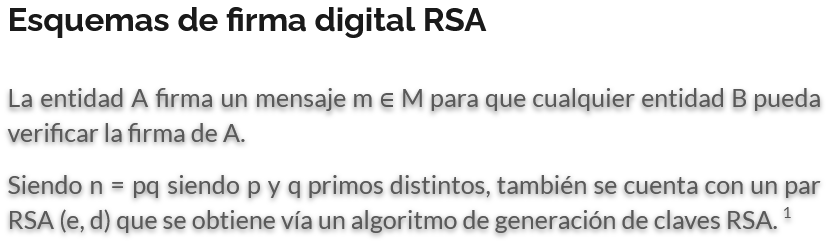

In [7]:
A = Entidad("A") 
B = Entidad("B")

A.generacionClave(NUMBER_BYTES)
A.claves

{'p': 12887767,
 'q': 2179589,
 'n': 28090035187763,
 'phi': 28090020120408,
 'e': 26106347026213,
 'd': 23600299769941}

In [8]:
R = CA() 
R.añadir(nombre=A.nombre,clave_publica=A.claves_publicas())

R.bd

[{'name': 'A', 'e': 26106347026213, 'n': 28090035187763}]

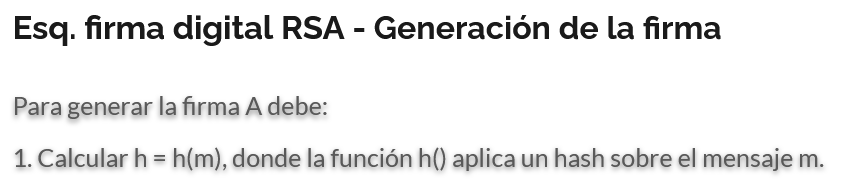

In [9]:
m = 'Introducción a la Criptografia'
print(m)

Introducción a la Criptografia


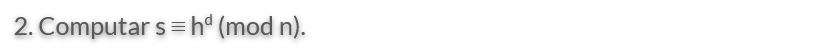

In [10]:
s = A.firmarMensaje(m)
print(s)

2877700293404


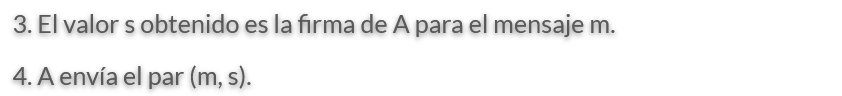

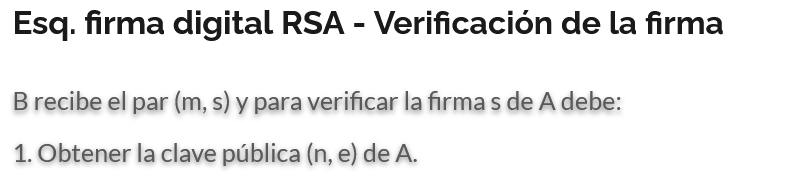

In [11]:
if B.buscar("A")==False: 
    B.añadirDatos(R.buscar("A"))
    
B.bd

[{'name': 'A', 'e': 26106347026213, 'n': 28090035187763}]

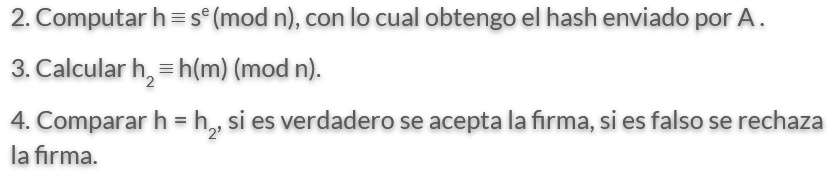

In [12]:
if B.verificarFirma(entidad="A", msje = m, firma = s):
    print("Aceptar firma")
else:
    print("No aceptar firma")


Aceptar firma
